<a href="https://colab.research.google.com/github/vishtantrik/flight-poster/blob/master/Explore_and_Prepare_Data_for_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flight Poster Project, Explore and Prepare Data for Visualization

## Setups

In [ ]:
from google.colab import auth, files
import gspread
from gspread_dataframe import set_with_dataframe, get_as_dataframe
from oauth2client.client import GoogleCredentials
import io
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import geopy.distance

## Flight Logs

### Get Data

In [ ]:
#@title
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())


In [ ]:
#@title
wb = gc.open('Flight Log')
ws = wb.worksheet('Logs')

In [ ]:
#@title
flight_logs_raw = ws.get_all_values()
flight_logs = pd.DataFrame(columns=flight_logs_raw[0], data=flight_logs_raw[1:])
# Pilot names are noted when it is not "Self". Substitute their names with "Other"
flight_logs['Pilot in Command'][flight_logs['Pilot in Command'] != 'Self'] = 'Other'
flight_logs_cols_to_keep = ['Sl. No.', 'Date',
       'Aircraft Type', 'Aircraft Regn', 'Pilot in Command',
       'Holder\'s Operating Capacity', 'Departure Place', 'Departure Time UTC',
       'Arrival Place', 'Arrival Time UTC', 'Day Landings', 'Night Landings',
       'Total Flight Time', 'SE Day Dual', 'SE Day PIC', 'SE Day PICUS',
       'SE Night Dual', 'SE Night PIC', 'SE Night PICUS', 'ME Day Dual',
       'ME Day PIC', 'ME Day PICUS', 'ME Day P2', 'ME Night Dual',
       'ME Night PIC', 'ME Night PICUS', 'ME Night P2', 'Other Flying IFT',
       'Other Flying SPIC', 'Other Flying NAV']
flight_logs = flight_logs[flight_logs_cols_to_keep]


### Verify and Clean Data

#### Clean Obvious Errors

In [ ]:
#@title
dep_time_missing = (flight_logs['Departure Time UTC'] == '')
arv_time_missing = (flight_logs['Arrival Time UTC'] == '')
date_missing = (flight_logs['Date'] == '')
rows_to_remove = dep_time_missing | arv_time_missing | date_missing
print('''Number of rows with:
  Missing date: {}
  Missing departure time: {}
  Missing arrival time: {}
  
Total number of rows missing crucial data: {}
These rows will be removed.'''.format(date_missing.sum(),
                                      dep_time_missing.sum(),
                                      arv_time_missing.sum(),
                                      rows_to_remove.sum()
                                      )
    )

flight_logs = flight_logs[~rows_to_remove]

Number of rows with:
  Missing date: 0
  Missing departure time: 1
  Missing arrival time: 2
  
Total number of rows missing crucial data: 2
These rows will be removed.


#### Add Calculated Fields

  - Convert duration columns to TimeDelta type
  - Convert Integer columns to Nullable Int type
  - Get Arrival and Departure DateTime's from Date, and Arrival and Departure Strings

In [ ]:
#@title
# Convert duration columns to TimeDelta type
def ConvertColumns(df, columns, converter):
  for column in columns:
    df[column] = df[column].map(converter)
  return(df)

cols_to_convert = ['Total Flight Time',
                   'SE Day Dual', 'SE Day PIC', 'SE Day PICUS',
                   'SE Night Dual', 'SE Night PIC', 'SE Night PICUS',
                   'ME Day Dual', 'ME Day PIC', 'ME Day PICUS', 'ME Day P2',
                   'ME Night Dual', 'ME Night PIC', 'ME Night PICUS', 'ME Night P2',
                   'Other Flying IFT', 'Other Flying SPIC', 'Other Flying NAV']
converter = lambda x: pd.to_timedelta(x+':00') if len(x) > 0 else pd.to_timedelta('0:00:00')

flight_logs = ConvertColumns(flight_logs, cols_to_convert, converter)

In [ ]:
#@title
# Convert Integer columns to Nullable Int type
def ColumnsToNullableInt(df, columns):
  for column in columns:
    df[column] = pd.to_numeric(df[column]).astype('Int64')
  return(df)

flight_logs = ColumnsToNullableInt(flight_logs, ['Sl. No.', 'Day Landings', 'Night Landings'])

In [ ]:
#@title
# Get Arrival and Departure DateTime's from Date, and Arrival and Departure Strings
def GetArrivalDepartureTimes(df_row):
  df_row['Departure Time'] = pd.to_datetime(df_row['Date'] + ' ' + df_row['Departure Time UTC'].rjust(4, '0'), format='%d-%b-%Y %H%M', utc=True)
  df_row['Arrival Time'] = pd.to_datetime(df_row['Date'] + ' ' + df_row['Arrival Time UTC'].rjust(4, '0'), format='%d-%b-%Y %H%M', utc=True)
  if df_row['Arrival Time'] < df_row['Departure Time']:
      df_row['Arrival Time'] = df_row['Arrival Time'] + pd.DateOffset(days=1)
  return df_row

flight_logs = flight_logs.apply(GetArrivalDepartureTimes, axis=1)


In [ ]:
#@title
# Display a sample of the data
flight_logs.head()

,Sl. No.,Date,Aircraft Type,Aircraft Regn,Pilot in Command,Holder's Operating Capacity,Departure Place,Departure Time UTC,Arrival Place,Arrival Time UTC,Day Landings,Night Landings,Total Flight Time,SE Day Dual,SE Day PIC,SE Day PICUS,SE Night Dual,SE Night PIC,SE Night PICUS,ME Day Dual,ME Day PIC,ME Day PICUS,ME Day P2,ME Night Dual,ME Night PIC,ME Night PICUS,ME Night P2,Other Flying IFT,Other Flying SPIC,Other Flying NAV,Departure Time,Arrival Time
0,1,25-Jan-2019,PA-28-181,N4400W,Other,PUT,KFFZ,2143,KFFZ,2301,<NA>,<NA>,0 days 01:18:00,0 days 01:18:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,2019-01-25 21:43:00+00:00,2019-01-25 23:01:00+00:00
1,2,27-Jan-2019,PA-28-181,N4400P,Other,PUT,KFFZ,2325,KFFZ,101,3,<NA>,0 days 01:36:00,0 days 01:36:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,2019-01-27 23:25:00+00:00,2019-01-28 01:01:00+00:00
2,3,1-Feb-2019,PA-28-181,N4403L,Other,PUT,KCGZ,1650,KFFZ,1820,<NA>,<NA>,0 days 01:30:00,0 days 01:30:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,2019-02-01 16:50:00+00:00,2019-02-01 18:20:00+00:00
3,4,2-Feb-2019,PA-28-181,N28614,Other,PUT,KFFZ,1430,KCGZ,1606,<NA>,<NA>,0 days 01:36:00,0 days 01:36:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,2019-02-02 14:30:00+00:00,2019-02-02 16:06:00+00:00
4,5,6-Feb-2019,PA-28-181,N4401F,Other,PUT,KFFZ,1854,KFFZ,2006,<NA>,<NA>,0 days 01:12:00,0 days 01:12:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,2019-02-06 18:54:00+00:00,2019-02-06 20:06:00+00:00


#### Inspect Data

Odd things noticed:

1. Min flight time is 24 mins.
  1. Log checked for flights shorter than 40 minutes. All of them look correct
1. First and last dates are NaN.
  1. This is becuase 'Date' is stored as a string. There are no null or empty values

##### General Data Inspection

In [ ]:
#@title
 flight_logs.describe()

,Sl. No.,Total Flight Time,SE Day Dual,SE Day PIC,SE Day PICUS,SE Night Dual,SE Night PIC,SE Night PICUS,ME Day Dual,ME Day PIC,ME Day PICUS,ME Day P2,ME Night Dual,ME Night PIC,ME Night PICUS,ME Night P2,Other Flying IFT,Other Flying SPIC,Other Flying NAV
count,127.000000,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127
mean,64.314961,0 days 01:55:33.543307086,0 days 00:43:44.881889763,0 days 00:40:34.960629921,0 days 00:01:44.881889763,0 days 00:05:23.149606299,0 days 00:07:19.370078740,0 days 00:00:00,0 days 00:11:40.157480314,0 days 00:00:00,0 days 00:00:51.023622047,0 days 00:00:00,0 days 00:04:15.118110236,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:21:32.598425196,0 days 00:00:00,0 days 00:29:17.480314960
std,37.271569,0 days 00:46:50.670012071,0 days 00:51:01.129282787,0 days 01:04:37.439810308,0 days 00:13:55.223443292,0 days 00:23:46.244764489,0 days 00:28:17.003777919,0 days 00:00:00,0 days 00:34:50.455249367,0 days 00:00:00,0 days 00:09:35.007018101,0 days 00:00:00,0 days 00:27:13.505756759,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:37:21.947570503,0 days 00:00:00,0 days 01:06:03.015520219
min,1.000000,0 days 00:24:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
25%,32.500000,0 days 01:30:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
50%,64.000000,0 days 01:42:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
75%,95.500000,0 days 02:21:00,0 days 01:30:00,0 days 01:36:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:30:00,0 days 00:00:00,0 days 00:00:00
max,129.000000,0 days 04:18:00,0 days 04:18:00,0 days 03:06:00,0 days 02:00:00,0 days 02:36:00,0 days 03:00:00,0 days 00:00:00,0 days 03:42:00,0 days 00:00:00,0 days 01:48:00,0 days 00:00:00,0 days 03:48:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 04:00:00,0 days 00:00:00,0 days 04:18:00


In [ ]:
#@title
flight_logs[['Date', 'Departure Time', 'Arrival Time']].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,Date,Departure Time,Arrival Time
count,127,127,127
unique,108,127,127
top,7-Dec-2019,2019-02-25 17:00:00+00:00,2019-02-10 00:44:00+00:00
freq,3,1,1
first,NaN,2019-01-25 21:43:00+00:00,2019-01-25 23:01:00+00:00
last,NaN,2020-03-30 21:53:00+00:00,2020-03-30 23:41:00+00:00


In [ ]:
#@title
flight_logs[['Departure Place', 'Arrival Place', 'Aircraft Type', 'Aircraft Regn', 'Pilot in Command']].describe()

,Departure Place,Arrival Place,Aircraft Type,Aircraft Regn,Pilot in Command
count,127,127,127,127,127
unique,10,11,3,33,2
top,KFFZ,KFFZ,PA-28-181,N424TS,Other
freq,109,108,107,12,85


In [ ]:
#@title
flight_logs[['Day Landings', 'Night Landings']].describe()

,Day Landings,Night Landings
count,111,21
unique,10,10
top,1,2
freq,32,5


In [ ]:
#@title
flight_logs['Aircraft Type'].unique()

array(['PA-28-181', 'DA-20-C1', 'DA-42-L360'], dtype=object)

##### Inspect Specific Issues

Originally dates weren't being converted properly resulting in empty and `NULL` dates. This has now been fixed.

In [ ]:
#@title
short_flights = flight_logs['Total Flight Time'] < pd.Timedelta(minutes=40)
flight_logs[short_flights].sort_values('Total Flight Time')

,Sl. No.,Date,Aircraft Type,Aircraft Regn,Pilot in Command,Holder's Operating Capacity,Departure Place,Departure Time UTC,Arrival Place,Arrival Time UTC,Day Landings,Night Landings,Total Flight Time,SE Day Dual,SE Day PIC,SE Day PICUS,SE Night Dual,SE Night PIC,SE Night PICUS,ME Day Dual,ME Day PIC,ME Day PICUS,ME Day P2,ME Night Dual,ME Night PIC,ME Night PICUS,ME Night P2,Other Flying IFT,Other Flying SPIC,Other Flying NAV,Departure Time,Arrival Time
28,29,23-Mar-2019,PA-28-181,N4404F,Self,PIC,KFFZ,1736,KFFZ,1800,1,<NA>,0 days 00:24:00,0 days 00:00:00,0 days 00:24:00,0 days,0 days,0 days,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,2019-03-23 17:36:00+00:00,2019-03-23 18:00:00+00:00
124,125,18-Mar-2020,DA-42-L360,N424TS,Other,PUT,KFFZ,2040,KFFZ,2110,1,<NA>,0 days 00:30:00,0 days 00:00:00,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days 00:30:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,2020-03-18 20:40:00+00:00,2020-03-18 21:10:00+00:00
22,23,12-Mar-2019,PA-28-181,N4401F,Other,PUT,KFFZ,1820,KFFZ,1856,1,<NA>,0 days 00:36:00,0 days 00:36:00,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,2019-03-12 18:20:00+00:00,2019-03-12 18:56:00+00:00
82,83,3-Nov-2019,PA-28-181,N28614,Self,PIC,KFFZ,2355,KFFZ,31,2,<NA>,0 days 00:36:00,0 days 00:00:00,0 days 00:36:00,0 days,0 days,0 days,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,2019-11-03 23:55:00+00:00,2019-11-04 00:31:00+00:00
105,106,7-Dec-2019,PA-28-181,N4400W,Self,PIC,KIGM,1700,KIFP,1736,1,<NA>,0 days 00:36:00,0 days 00:00:00,0 days 00:36:00,0 days,0 days,0 days,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,2019-12-07 17:00:00+00:00,2019-12-07 17:36:00+00:00


In [ ]:
#@title
type(flight_logs['Date'][0])

str

In [ ]:
#@title
print('''The number of empty 'Date's = {}
The number of Null 'Date's = {}'''.format((flight_logs['Date'] == '').sum(),
                                          flight_logs['Date'].isnull().sum())
)

The number of empty 'Date's = 0
The number of Null 'Date's = 0


### Add Fields


#### Add Airport Lat Longs

In [ ]:
#@title
# List all arrival departure airports
airports_of_int = list(set(
    list(flight_logs['Arrival Place'].unique())
     + list(flight_logs['Departure Place'].unique())
     ))
airports_of_int

['KCGZ',
 'KIFP',
 'KAVQ',
 'KCHD',
 'KCRQ',
 'KIWA',
 'KSEZ',
 'KP08',
 'KIGM',
 'KHII',
 'KELP',
 'KNYL',
 'KFFZ']

In [ ]:
#@title
# Get worldwide airports data
data_url = 'https://raw.githubusercontent.com/datasets/airport-codes/master/data/airport-codes.csv'
airports_df = pd.read_csv(data_url, index_col=0)

# Get data and Verify that data exists for airports of interest
airports_of_int_data = airports_df[airports_df.index.isin(airports_of_int)]

if len(airports_of_int_data) != len(airports_of_int):
  raise AssertionError("Data not found for all airports of interest")

airports_df_cols_to_keep = ['name', 'iso_region', 'elevation_ft', 'coordinates']
# Parse lat-long float values from coordinates string
airports_of_int_data = airports_of_int_data[airports_df_cols_to_keep]
lat_long = airports_of_int_data['coordinates'].str.split(',', expand=True)
airports_of_int_data['latitude'] = lat_long[0].astype(float)
airports_of_int_data['longitude'] = lat_long[1].astype(float)
airports_of_int_data.drop(columns=['coordinates'], inplace=True)
airports_of_int_data.rename(columns = {'name':'Name', 'iso_region':'ISO Region',
                                       'elevation_ft': 'Elevation (ft)', 
                                       'latitude':'Latitude',
                                       'longitude':'Longitude'},
                            inplace=True)
airports_of_int_data

,Name,ISO Region,Elevation (ft),Latitude,Longitude
ident,,,,,
KAVQ,Marana Regional Airport,US-AZ,2031.0,32.409599,-111.218002
KCGZ,Casa Grande Municipal Airport,US-AZ,1464.0,32.954899,-111.766998
KCHD,Chandler Municipal Airport,US-AZ,1243.0,33.269100,-111.810997
KCRQ,Mc Clellan-Palomar Airport,US-CA,331.0,33.128300,-117.279999
KELP,El Paso International Airport,US-TX,3959.0,31.807199,-106.377998
KFFZ,Falcon Field,US-AZ,1394.0,33.460800,-111.727997
KHII,Lake Havasu City Airport,US-AZ,783.0,34.571098,-114.358002
KIFP,Laughlin Bullhead International Airport,US-AZ,701.0,35.157398,-114.559998
KIGM,Kingman Airport,US-AZ,3449.0,35.259499,-113.938004


In [ ]:
#@title
# Join airport data to 
flight_logs = flight_logs.join(airports_of_int_data.add_prefix('Arrival Airport '),
                               how='left', on='Arrival Place')
flight_logs = flight_logs.join(airports_of_int_data.add_prefix('Departure Airport '),
                               how='left', on='Departure Place')

flight_logs.head()

,Sl. No.,Date,Aircraft Type,Aircraft Regn,Pilot in Command,Holder's Operating Capacity,Departure Place,Departure Time UTC,Arrival Place,Arrival Time UTC,Day Landings,Night Landings,Total Flight Time,SE Day Dual,SE Day PIC,SE Day PICUS,SE Night Dual,SE Night PIC,SE Night PICUS,ME Day Dual,ME Day PIC,ME Day PICUS,ME Day P2,ME Night Dual,ME Night PIC,ME Night PICUS,ME Night P2,Other Flying IFT,Other Flying SPIC,Other Flying NAV,Departure Time,Arrival Time,Arrival Airport Name,Arrival Airport ISO Region,Arrival Airport Elevation (ft),Arrival Airport Latitude,Arrival Airport Longitude,Departure Airport Name,Departure Airport ISO Region,Departure Airport Elevation (ft),Departure Airport Latitude,Departure Airport Longitude
0,1,25-Jan-2019,PA-28-181,N4400W,Other,PUT,KFFZ,2143,KFFZ,2301,<NA>,<NA>,0 days 01:18:00,0 days 01:18:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,2019-01-25 21:43:00+00:00,2019-01-25 23:01:00+00:00,Falcon Field,US-AZ,1394.0,33.460800,-111.727997,Falcon Field,US-AZ,1394.0,33.460800,-111.727997
1,2,27-Jan-2019,PA-28-181,N4400P,Other,PUT,KFFZ,2325,KFFZ,101,3,<NA>,0 days 01:36:00,0 days 01:36:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,2019-01-27 23:25:00+00:00,2019-01-28 01:01:00+00:00,Falcon Field,US-AZ,1394.0,33.460800,-111.727997,Falcon Field,US-AZ,1394.0,33.460800,-111.727997
2,3,1-Feb-2019,PA-28-181,N4403L,Other,PUT,KCGZ,1650,KFFZ,1820,<NA>,<NA>,0 days 01:30:00,0 days 01:30:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,2019-02-01 16:50:00+00:00,2019-02-01 18:20:00+00:00,Falcon Field,US-AZ,1394.0,33.460800,-111.727997,Casa Grande Municipal Airport,US-AZ,1464.0,32.954899,-111.766998
3,4,2-Feb-2019,PA-28-181,N28614,Other,PUT,KFFZ,1430,KCGZ,1606,<NA>,<NA>,0 days 01:36:00,0 days 01:36:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,2019-02-02 14:30:00+00:00,2019-02-02 16:06:00+00:00,Casa Grande Municipal Airport,US-AZ,1464.0,32.954899,-111.766998,Falcon Field,US-AZ,1394.0,33.460800,-111.727997
4,5,6-Feb-2019,PA-28-181,N4401F,Other,PUT,KFFZ,1854,KFFZ,2006,<NA>,<NA>,0 days 01:12:00,0 days 01:12:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,2019-02-06 18:54:00+00:00,2019-02-06 20:06:00+00:00,Falcon Field,US-AZ,1394.0,33.460800,-111.727997,Falcon Field,US-AZ,1394.0,33.460800,-111.727997


### Re-arrange Data

In [ ]:
#@title
arv_dep_cols = ['Place', 'Time']
airport_cols = ['Name', 'ISO Region', 'Elevation (ft)', 'Latitude', 'Longitude']

In [ ]:
#@title
arv_cols = (['Arrival {}'.format(x) for x in arv_dep_cols] +
            ['Arrival Airport {}'.format(x) for x in airport_cols])
dep_cols = (['Departure {}'.format(x) for x in arv_dep_cols] +
            ['Departure Airport {}'.format(x) for x in airport_cols])
duration_cols = ['Total Flight Time',
                 'SE Day Dual', 'SE Day PIC', 'SE Day PICUS',
                 'SE Night Dual', 'SE Night PIC', 'SE Night PICUS',
                 'ME Day Dual', 'ME Day PIC', 'ME Day PICUS', 'ME Day P2',
                 'ME Night Dual', 'ME Night PIC', 'ME Night PICUS', 'ME Night P2',
                 'Other Flying IFT', 'Other Flying SPIC', 'Other Flying NAV']
fl_cols_to_keep = (['Sl. No.', 'Aircraft Type', 'Aircraft Regn',
                    'Pilot in Command', "Holder's Operating Capacity"] +
                   dep_cols + arv_cols +
                   ['Day Landings', 'Night Landings'] +
                   duration_cols)
flight_logs = flight_logs[fl_cols_to_keep]
flight_logs.head()

,Sl. No.,Aircraft Type,Aircraft Regn,Pilot in Command,Holder's Operating Capacity,Departure Place,Departure Time,Departure Airport Name,Departure Airport ISO Region,Departure Airport Elevation (ft),Departure Airport Latitude,Departure Airport Longitude,Arrival Place,Arrival Time,Arrival Airport Name,Arrival Airport ISO Region,Arrival Airport Elevation (ft),Arrival Airport Latitude,Arrival Airport Longitude,Day Landings,Night Landings,Total Flight Time,SE Day Dual,SE Day PIC,SE Day PICUS,SE Night Dual,SE Night PIC,SE Night PICUS,ME Day Dual,ME Day PIC,ME Day PICUS,ME Day P2,ME Night Dual,ME Night PIC,ME Night PICUS,ME Night P2,Other Flying IFT,Other Flying SPIC,Other Flying NAV
0,1,PA-28-181,N4400W,Other,PUT,KFFZ,2019-01-25 21:43:00+00:00,Falcon Field,US-AZ,1394.0,33.460800,-111.727997,KFFZ,2019-01-25 23:01:00+00:00,Falcon Field,US-AZ,1394.0,33.460800,-111.727997,<NA>,<NA>,0 days 01:18:00,0 days 01:18:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days
1,2,PA-28-181,N4400P,Other,PUT,KFFZ,2019-01-27 23:25:00+00:00,Falcon Field,US-AZ,1394.0,33.460800,-111.727997,KFFZ,2019-01-28 01:01:00+00:00,Falcon Field,US-AZ,1394.0,33.460800,-111.727997,3,<NA>,0 days 01:36:00,0 days 01:36:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days
2,3,PA-28-181,N4403L,Other,PUT,KCGZ,2019-02-01 16:50:00+00:00,Casa Grande Municipal Airport,US-AZ,1464.0,32.954899,-111.766998,KFFZ,2019-02-01 18:20:00+00:00,Falcon Field,US-AZ,1394.0,33.460800,-111.727997,<NA>,<NA>,0 days 01:30:00,0 days 01:30:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days
3,4,PA-28-181,N28614,Other,PUT,KFFZ,2019-02-02 14:30:00+00:00,Falcon Field,US-AZ,1394.0,33.460800,-111.727997,KCGZ,2019-02-02 16:06:00+00:00,Casa Grande Municipal Airport,US-AZ,1464.0,32.954899,-111.766998,<NA>,<NA>,0 days 01:36:00,0 days 01:36:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days
4,5,PA-28-181,N4401F,Other,PUT,KFFZ,2019-02-06 18:54:00+00:00,Falcon Field,US-AZ,1394.0,33.460800,-111.727997,KFFZ,2019-02-06 20:06:00+00:00,Falcon Field,US-AZ,1394.0,33.460800,-111.727997,<NA>,<NA>,0 days 01:12:00,0 days 01:12:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days


## Flight Tracks

### Get Data

##### Flight Track Data

In [ ]:
#@title
uploaded = files.upload()

Saving Flight_Tracks_Consolidated.csv to Flight_Tracks_Consolidated (3).csv


In [ ]:
#@title
# Verify that only 1 file was uploaded
if len(uploaded) == 0:
  raise AssertionError('No files were uploaded')
if len(uploaded) > 1:
  raise AssertionError('More than 1 file was uploaded')

In [ ]:
#@title
flight_tracks_fname = list(uploaded.keys())[0]
(uploaded[flight_tracks_fname])
flight_tracks = pd.read_csv(io.BytesIO(uploaded[flight_tracks_fname]),
                            parse_dates=['UTC'],
                            converters={'Timestamp':
                                        lambda x: pd.to_datetime(x, unit='s')})
flight_tracks.head()

,Filename,Timestamp,UTC,Callsign,Position,Altitude,Speed,Direction
0,1f5ddd09,2019-02-01 17:12:34,2019-02-01 17:12:34+00:00,OXF121,"32.954144,-111.768456",1375,110,58
1,1f5ddd09,2019-02-01 17:12:44,2019-02-01 17:12:44+00:00,OXF121,"32.955681,-111.764923",1450,81,64
2,1f5ddd09,2019-02-01 17:12:59,2019-02-01 17:12:59+00:00,OXF121,"32.958332,-111.759155",1625,72,59
3,1f5ddd09,2019-02-01 17:13:10,2019-02-01 17:13:10+00:00,OXF121,"32.960148,-111.755287",1700,98,60
4,1f5ddd09,2019-02-01 17:13:20,2019-02-01 17:13:20+00:00,OXF121,"32.961964,-111.751472",1775,136,60


##### Flight Num to Tail Num Mapping

It was found that many flight track flights report the flight number instead of the tail number as the "Callsign". However, all flight logs are maintined using the tail number. Hence we need the mapping between flight numbers and tail numbers. This has been manually extarcted from www.radarbox.com . 

The following code was used to compare the `Callsign` in the flight track data to `regn` from the flight log data and write it to a spreadsheet.

```
flight_logs_regn = pd.DataFrame(flight_logs['Aircraft Regn'].unique(), columns=['Regn'])
flight_tracks_regn = pd.DataFrame(flight_tracks['Callsign'].unique(), columns=['Regn'])
regns_callsigns = pd.merge(flight_logs_regn, flight_tracks_regn, 'outer',
                           'Regn', suffixes = ('Logs', 'Tracks'),
                           indicator=True).sort_values('_merge')
wb = gc.open('Flight Log')
ws = wb.worksheet('Regns_CallSigns')
set_with_dataframe(ws, regns_callsigns)
```

In [ ]:
#@title
wb = gc.open('Flight Log')
ws = wb.worksheet('Map Flight Num to Tail Num')
flight_num_to_tail_num_map = get_as_dataframe(ws, usecols=[0,1])
flight_num_to_tail_num_map = flight_num_to_tail_num_map[~flight_num_to_tail_num_map.tail_num.isna()]
flight_num_to_tail_num_map = flight_num_to_tail_num_map.set_index('flight_num')['tail_num'].to_dict()

### Verify and Clean Data

In [ ]:
#@title
flight_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58103 entries, 0 to 58102
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   Filename   58103 non-null  object             
 1   Timestamp  58103 non-null  datetime64[ns]     
 2   UTC        58103 non-null  datetime64[ns, UTC]
 3   Callsign   58103 non-null  object             
 4   Position   58103 non-null  object             
 5   Altitude   58103 non-null  int64              
 6   Speed      58103 non-null  int64              
 7   Direction  58103 non-null  int64              
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), int64(3), object(3)
memory usage: 3.5+ MB


In [ ]:
#@title
# Verify that no file has been appended twice
if (flight_tracks['Filename'] +
    flight_tracks['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
    ).groupby(level=0).count().max() > 1:
    raise AssertionError('A timestamp-file combiation appears twice' +
                         'Check if a file has been appended twice in creating the consolidated flight track CSV')

##### Add Tail Number


In [ ]:
#@title
callsigns = flight_tracks['Callsign']
mapped_tail_nums = callsigns.map(flight_num_to_tail_num_map, na_action='ignore')
tail_nums = mapped_tail_nums.mask(pd.isna, callsigns)
flight_tracks['Tail Number'] = tail_nums
flight_tracks.head()

,Filename,Timestamp,UTC,Callsign,Position,Altitude,Speed,Direction,Tail Number
0,1f5ddd09,2019-02-01 17:12:34,2019-02-01 17:12:34+00:00,OXF121,"32.954144,-111.768456",1375,110,58,N4403L
1,1f5ddd09,2019-02-01 17:12:44,2019-02-01 17:12:44+00:00,OXF121,"32.955681,-111.764923",1450,81,64,N4403L
2,1f5ddd09,2019-02-01 17:12:59,2019-02-01 17:12:59+00:00,OXF121,"32.958332,-111.759155",1625,72,59,N4403L
3,1f5ddd09,2019-02-01 17:13:10,2019-02-01 17:13:10+00:00,OXF121,"32.960148,-111.755287",1700,98,60,N4403L
4,1f5ddd09,2019-02-01 17:13:20,2019-02-01 17:13:20+00:00,OXF121,"32.961964,-111.751472",1775,136,60,N4403L


#### Add Calculated Fields

  - Split `Position` string to `Latitude` and `Longitude`
  - Compute distance travelled between 2 consecutive timestamps
  - Infer speed and acceleration from distance travelled

In [ ]:
#@title
lat_long = flight_tracks['Position'].str.split(",", expand=True)
flight_tracks['Latitude'] = lat_long[0].astype(float)
flight_tracks['Longitude'] = lat_long[1].astype(float)
flight_tracks.drop(columns=['Position'], inplace=True)

In [ ]:
#@title
flight_tracks.head()

,Filename,Timestamp,UTC,Callsign,Altitude,Speed,Direction,Tail Number,Latitude,Longitude
0,1f5ddd09,2019-02-01 17:12:34,2019-02-01 17:12:34+00:00,OXF121,1375,110,58,N4403L,32.954144,-111.768456
1,1f5ddd09,2019-02-01 17:12:44,2019-02-01 17:12:44+00:00,OXF121,1450,81,64,N4403L,32.955681,-111.764923
2,1f5ddd09,2019-02-01 17:12:59,2019-02-01 17:12:59+00:00,OXF121,1625,72,59,N4403L,32.958332,-111.759155
3,1f5ddd09,2019-02-01 17:13:10,2019-02-01 17:13:10+00:00,OXF121,1700,98,60,N4403L,32.960148,-111.755287
4,1f5ddd09,2019-02-01 17:13:20,2019-02-01 17:13:20+00:00,OXF121,1775,136,60,N4403L,32.961964,-111.751472


In [ ]:
#@title
def ComputeDistanceKM(lat1, long1, lat2, long2):
  if np.isnan(lat1) | np.isnan(long1) | np.isnan(lat2) | np.isnan(long2):
    return np.nan
  else:
    return geopy.distance.distance((lat1, long1), (lat2, long2)).km

In [ ]:
#@title
flight_tracks['Latitude Previous']= flight_tracks.groupby('Filename')['Latitude'].shift(1)
flight_tracks['Longitude Previous']= flight_tracks.groupby('Filename')['Longitude'].shift(1)
flight_tracks['Distance (m)'] = flight_tracks.apply(lambda x: ComputeDistanceKM(x['Latitude'], x['Longitude'], x['Latitude Previous'], x['Longitude Previous']) * 1000, axis=1)
flight_tracks['Speed Delta'] = flight_tracks.groupby('Filename')['Speed'].diff() 
flight_tracks['Time Delta'] = flight_tracks.groupby('Filename')['UTC'].diff()
flight_tracks['Inferred Speed (kts)'] = flight_tracks['Distance (m)'] / flight_tracks['Time Delta'].dt.total_seconds() / 0.5144
flight_tracks['Inferred Acceleration (m/s^2)'] = flight_tracks['Speed Delta'] * 0.5144 / flight_tracks['Time Delta'].dt.total_seconds()

flight_tracks.drop(columns=['Latitude Previous', 'Longitude Previous', 'Speed Delta'], inplace=True)
flight_tracks.head()

,Filename,Timestamp,UTC,Callsign,Altitude,Speed,Direction,Tail Number,Latitude,Longitude,Distance (m),Time Delta,Inferred Speed (kts),Inferred Acceleration (m/s^2)
0,1f5ddd09,2019-02-01 17:12:34,2019-02-01 17:12:34+00:00,OXF121,1375,110,58,N4403L,32.954144,-111.768456,NaN,NaT,NaN,NaN
1,1f5ddd09,2019-02-01 17:12:44,2019-02-01 17:12:44+00:00,OXF121,1450,81,64,N4403L,32.955681,-111.764923,371.724982,0 days 00:00:10,72.263799,-1.491760
2,1f5ddd09,2019-02-01 17:12:59,2019-02-01 17:12:59+00:00,OXF121,1625,72,59,N4403L,32.958332,-111.759155,614.233844,0 days 00:00:15,79.605216,-0.308640
3,1f5ddd09,2019-02-01 17:13:10,2019-02-01 17:13:10+00:00,OXF121,1700,98,60,N4403L,32.960148,-111.755287,413.942271,0 days 00:00:11,73.155357,1.215855
4,1f5ddd09,2019-02-01 17:13:20,2019-02-01 17:13:20+00:00,OXF121,1775,136,60,N4403L,32.961964,-111.751472,409.613818,0 days 00:00:10,79.629436,1.954720


#### Inspect Data

##### General Data Inspection

Odd things:

1. Max speed of 512 knots seems very high. Max air speed for the aircrafts flown is around 200 knots. Pilot confirms that the maximum speed they have flown is around 200 knots.

In [ ]:
#@title
flight_tracks.describe()

,Altitude,Speed,Direction,Latitude,Longitude,Distance (m),Time Delta,Inferred Speed (kts),Inferred Acceleration (m/s^2)
count,58103.000000,58103.000000,58103.000000,58103.000000,58103.000000,57964.000000,57964,57964.000000,57964.000000
mean,4300.410048,99.300983,183.765709,33.256001,-111.831350,561.069216,0 days 00:00:14.522013663,98.864801,-0.002597
std,2391.485888,26.846035,104.251039,0.462722,0.805761,551.989165,0 days 00:03:51.596198470,29.737066,0.327719
min,0.000000,0.000000,1.000000,31.738861,-117.487289,0.000000,0 days 00:00:06,0.000000,-21.501920
25%,2425.000000,87.000000,89.000000,33.001452,-111.888428,344.777859,0 days 00:00:07,84.763334,-0.102880
50%,3800.000000,101.000000,188.000000,33.238129,-111.733650,495.709878,0 days 00:00:10,100.798404,0.000000
75%,5875.000000,115.000000,270.000000,33.459236,-111.565689,695.380901,0 days 00:00:12,116.773452,0.102880
max,12425.000000,512.000000,359.000000,36.351013,-106.369576,49139.722936,0 days 12:34:42,604.837984,6.121360


In [ ]:
#@title
flight_tracks[['Filename', 'Callsign']].describe()

,Filename,Callsign
count,58103,58103
unique,139,40
top,22833f38,OXF1910
freq,1076,5665


##### Inspect Specific Issues

###### Speed and Position


Based on plots of speed and inferred acceleration it looks like speed data can be problematic and easy to identify. I will reset speed data to NaN for rows with speed > 220 kts or inferred acceleration > 5 m/s^2.

Based on plots of inferred speed it looks like position information may also be erroneous sometimes but this is harder to identify. Because of this and because position data is generally considered being more reliable than speed data I will not apply any filtering to position data. This may need to be revisited if later visualizations show erroneous position data.

In [ ]:
bin_edges = np.append(-np.inf, np.append(np.arange(-50, 650, 50), np.inf))
speed_cuts = pd.cut(flight_tracks['Speed'], bins=bin_edges)
speed_cuts.groupby(speed_cuts).count()

Speed
(-inf, -50.0]         0
(-50.0, 0.0]        310
(0.0, 50.0]        2601
(50.0, 100.0]     25142
(100.0, 150.0]    28998
(150.0, 200.0]     1030
(200.0, 250.0]       17
(250.0, 300.0]        0
(300.0, 350.0]        3
(350.0, 400.0]        1
(400.0, 450.0]        0
(450.0, 500.0]        0
(500.0, 550.0]        1
(550.0, 600.0]        0
(600.0, inf]          0
Name: Speed, dtype: int64

In [ ]:
high_speed = flight_tracks['Speed'] > 300
nearby_rows = (high_speed.shift(2) | high_speed.shift(1) |
               high_speed.shift(-1) | high_speed.shift(-2))
flight_tracks[(high_speed | nearby_rows)]

,Filename,Timestamp,UTC,Callsign,Altitude,Speed,Direction,Tail Number,Latitude,Longitude,Distance (m),Time Delta,Inferred Speed (kts),Inferred Acceleration (m/s^2)
1068,1f6d5d32,2019-02-07 17:41:34,2019-02-07 17:41:34+00:00,N4403N,2150,120,313,N4403N,32.987007,-111.741158,563.612002,0 days 00:00:10,109.566874,0.771600
1069,1f6d5d32,2019-02-07 17:41:40,2019-02-07 17:41:40+00:00,N4403N,2100,144,294,N4403N,32.988079,-111.744072,297.178652,0 days 00:00:06,96.286499,2.057600
1070,1f6d5d32,2019-02-07 17:42:34,2019-02-07 17:42:34+00:00,N4403N,2075,301,231,N4403N,32.976486,-111.774513,3122.375554,0 days 00:00:54,112.406239,1.495570
1071,1f6d5d32,2019-02-07 17:42:45,2019-02-07 17:42:45+00:00,N4403N,2050,147,238,N4403N,32.973602,-111.779839,591.758939,0 days 00:00:11,104.580613,-7.201600
1072,1f6d5d32,2019-02-07 17:42:56,2019-02-07 17:42:56+00:00,N4403N,2050,180,238,N4403N,32.970901,-111.784821,553.746535,0 days 00:00:11,97.862741,1.543200
1136,1f6d5d32,2019-02-07 17:55:50,2019-02-07 17:55:50+00:00,N4403N,1550,151,56,N4403N,32.952419,-111.772041,481.969055,0 days 00:00:10,93.695384,3.600800
1137,1f6d5d32,2019-02-07 17:55:57,2019-02-07 17:55:57+00:00,N4403N,1625,36,56,N4403N,32.953957,-111.769295,308.251030,0 days 00:00:07,85.606262,-8.450857
1138,1f6d5d32,2019-02-07 17:56:41,2019-02-07 17:56:41+00:00,N4403N,2175,512,55,N4403N,32.963638,-111.752312,1916.773693,0 days 00:00:44,84.687089,5.564873
1139,1f6d5d32,2019-02-07 17:56:51,2019-02-07 17:56:51+00:00,N4403N,2275,94,53,N4403N,32.965782,-111.748726,411.017347,0 days 00:00:10,79.902284,-21.501920
1140,1f6d5d32,2019-02-07 17:57:01,2019-02-07 17:57:01+00:00,N4403N,2450,76,52,N4403N,32.967831,-111.745308,392.105135,0 days 00:00:10,76.225726,-0.925920


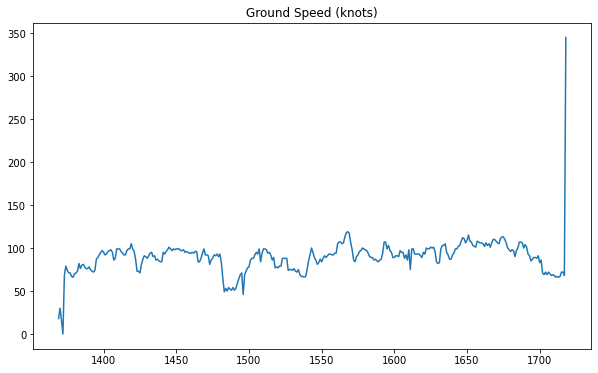

In [ ]:
select_files = flight_tracks[flight_tracks['Speed'] > 300]['Filename'].values
rand_select_file = np.random.choice(select_files, 1)[0]
df_rand_select_file = flight_tracks[flight_tracks['Filename'] == rand_select_file].copy()

fig = plt.figure(figsize=(10,6))
df_rand_select_file['Speed'].plot(title='Ground Speed (knots)')

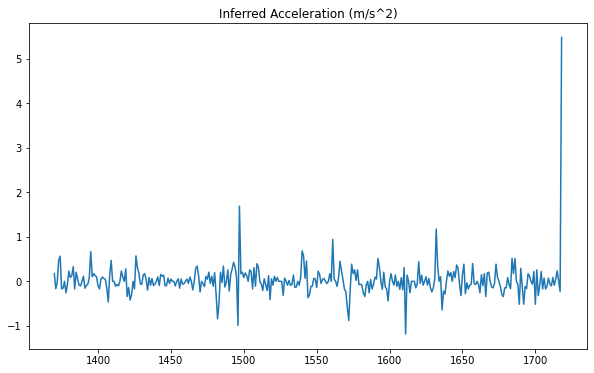

In [ ]:
fig = plt.figure(figsize=(10,6))
df_rand_select_file['Inferred Acceleration (m/s^2)'].plot(title='Inferred Acceleration (m/s^2)')

In [ ]:
high_accel = df_rand_select_file['Inferred Acceleration (m/s^2)'].abs() > 5
df_rand_select_file[high_accel |
                    high_accel.shift(2) | high_accel.shift(1) |
                    high_accel.shift(-1) | high_accel.shift(-2)]

,Filename,Timestamp,UTC,Callsign,Altitude,Speed,Direction,Tail Number,Latitude,Longitude,Distance (m),Time Delta,Inferred Speed (kts),Inferred Acceleration (m/s^2)
1716,1f705ea0,2019-02-08 20:17:01,2019-02-08 20:17:01+00:00,N4403W,1425,72,62,N4403W,32.950470,-111.775833,336.902164,0 days 00:00:10,65.494200,0.000000
1717,1f705ea0,2019-02-08 20:17:10,2019-02-08 20:17:10+00:00,N4403W,1375,68,60,N4403W,32.951843,-111.773087,298.519697,0 days 00:00:09,64.480667,-0.228622
1718,1f705ea0,2019-02-08 20:17:36,2019-02-08 20:17:36+00:00,N4403W,1350,345,239,N4403W,32.954842,-111.766998,659.367998,0 days 00:00:26,49.300754,5.480338


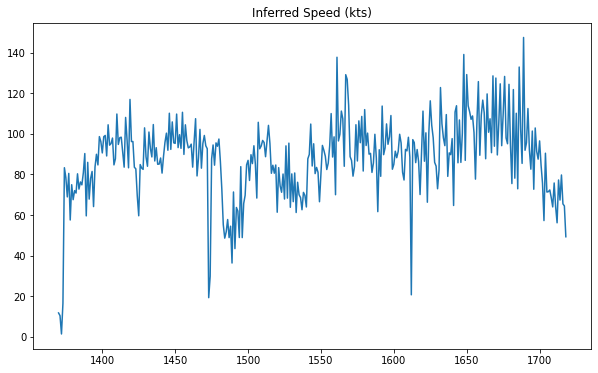

In [ ]:
fig = plt.figure(figsize=(10,6))
df_rand_select_file['Inferred Speed (kts)'].plot(title='Inferred Speed (kts)')

###### Altitude

Altitude data looks reasonable. Confirmed with the pilot that max altitude was around 12,000 feet.

In [ ]:
bin_edges = np.append(-np.inf, np.append(np.arange(-500, 13000, 500), np.inf))
cuts = pd.cut(flight_tracks['Altitude'], bins=bin_edges, right=False)
cuts.groupby(cuts).count()

Altitude
[-inf, -500.0)           0
[-500.0, 0.0)            0
[0.0, 500.0)          2675
[500.0, 1000.0)         70
[1000.0, 1500.0)      1289
[1500.0, 2000.0)      3700
[2000.0, 2500.0)      8009
[2500.0, 3000.0)      3647
[3000.0, 3500.0)      5634
[3500.0, 4000.0)      5407
[4000.0, 4500.0)      3416
[4500.0, 5000.0)      3407
[5000.0, 5500.0)      3331
[5500.0, 6000.0)      3460
[6000.0, 6500.0)      3073
[6500.0, 7000.0)      2789
[7000.0, 7500.0)      2419
[7500.0, 8000.0)      1717
[8000.0, 8500.0)      1044
[8500.0, 9000.0)       314
[9000.0, 9500.0)       340
[9500.0, 10000.0)      596
[10000.0, 10500.0)    1133
[10500.0, 11000.0)     231
[11000.0, 11500.0)     285
[11500.0, 12000.0)      34
[12000.0, 12500.0)      83
[12500.0, inf)           0
Name: Altitude, dtype: int64

#### Clean Data

- Reset speed to `NaN` where speed > 220 kts or where absolute inferred acceleration > 5 m/s^2

In [ ]:
bad_speed_mask = (flight_tracks['Speed'] > 220) | (flight_tracks['Inferred Acceleration (m/s^2)'].abs() > 5 )
flight_tracks.loc[bad_speed_mask, 'Speed'] = np.nan

## Join Flight Logs and Flight Tracks

In [ ]:
#@title
flight_logs.head()

,Sl. No.,Aircraft Type,Aircraft Regn,Pilot in Command,Holder's Operating Capacity,Departure Place,Departure Time,Departure Airport Name,Departure Airport ISO Region,Departure Airport Elevation (ft),Departure Airport Latitude,Departure Airport Longitude,Arrival Place,Arrival Time,Arrival Airport Name,Arrival Airport ISO Region,Arrival Airport Elevation (ft),Arrival Airport Latitude,Arrival Airport Longitude,Day Landings,Night Landings,Total Flight Time,SE Day Dual,SE Day PIC,SE Day PICUS,SE Night Dual,SE Night PIC,SE Night PICUS,ME Day Dual,ME Day PIC,ME Day PICUS,ME Day P2,ME Night Dual,ME Night PIC,ME Night PICUS,ME Night P2,Other Flying IFT,Other Flying SPIC,Other Flying NAV
0,1,PA-28-181,N4400W,Other,PUT,KFFZ,2019-01-25 21:43:00+00:00,Falcon Field,US-AZ,1394.0,33.460800,-111.727997,KFFZ,2019-01-25 23:01:00+00:00,Falcon Field,US-AZ,1394.0,33.460800,-111.727997,<NA>,<NA>,0 days 01:18:00,0 days 01:18:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days
1,2,PA-28-181,N4400P,Other,PUT,KFFZ,2019-01-27 23:25:00+00:00,Falcon Field,US-AZ,1394.0,33.460800,-111.727997,KFFZ,2019-01-28 01:01:00+00:00,Falcon Field,US-AZ,1394.0,33.460800,-111.727997,3,<NA>,0 days 01:36:00,0 days 01:36:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days
2,3,PA-28-181,N4403L,Other,PUT,KCGZ,2019-02-01 16:50:00+00:00,Casa Grande Municipal Airport,US-AZ,1464.0,32.954899,-111.766998,KFFZ,2019-02-01 18:20:00+00:00,Falcon Field,US-AZ,1394.0,33.460800,-111.727997,<NA>,<NA>,0 days 01:30:00,0 days 01:30:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days
3,4,PA-28-181,N28614,Other,PUT,KFFZ,2019-02-02 14:30:00+00:00,Falcon Field,US-AZ,1394.0,33.460800,-111.727997,KCGZ,2019-02-02 16:06:00+00:00,Casa Grande Municipal Airport,US-AZ,1464.0,32.954899,-111.766998,<NA>,<NA>,0 days 01:36:00,0 days 01:36:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days
4,5,PA-28-181,N4401F,Other,PUT,KFFZ,2019-02-06 18:54:00+00:00,Falcon Field,US-AZ,1394.0,33.460800,-111.727997,KFFZ,2019-02-06 20:06:00+00:00,Falcon Field,US-AZ,1394.0,33.460800,-111.727997,<NA>,<NA>,0 days 01:12:00,0 days 01:12:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days


In [ ]:
#@title
flight_tracks.head()

,Filename,Timestamp,UTC,Callsign,Altitude,Speed,Direction,Tail Number,Latitude,Longitude,Distance (m),Time Delta,Inferred Speed (kts),Inferred Acceleration (m/s^2)
0,1f5ddd09,2019-02-01 17:12:34,2019-02-01 17:12:34+00:00,OXF121,1375,110.0,58,N4403L,32.954144,-111.768456,NaN,NaT,NaN,NaN
1,1f5ddd09,2019-02-01 17:12:44,2019-02-01 17:12:44+00:00,OXF121,1450,81.0,64,N4403L,32.955681,-111.764923,371.724982,0 days 00:00:10,72.263799,-1.491760
2,1f5ddd09,2019-02-01 17:12:59,2019-02-01 17:12:59+00:00,OXF121,1625,72.0,59,N4403L,32.958332,-111.759155,614.233844,0 days 00:00:15,79.605216,-0.308640
3,1f5ddd09,2019-02-01 17:13:10,2019-02-01 17:13:10+00:00,OXF121,1700,98.0,60,N4403L,32.960148,-111.755287,413.942271,0 days 00:00:11,73.155357,1.215855
4,1f5ddd09,2019-02-01 17:13:20,2019-02-01 17:13:20+00:00,OXF121,1775,136.0,60,N4403L,32.961964,-111.751472,409.613818,0 days 00:00:10,79.629436,1.954720


In [ ]:
#@title
# Join tracks to logs using Callsign
logs_tracks_temp = pd.merge(flight_logs, flight_tracks, how='left', left_on='Aircraft Regn', right_on='Tail Number')
logs_tracks_temp.head()

,Sl. No.,Aircraft Type,Aircraft Regn,Pilot in Command,Holder's Operating Capacity,Departure Place,Departure Time,Departure Airport Name,Departure Airport ISO Region,Departure Airport Elevation (ft),Departure Airport Latitude,Departure Airport Longitude,Arrival Place,Arrival Time,Arrival Airport Name,Arrival Airport ISO Region,Arrival Airport Elevation (ft),Arrival Airport Latitude,Arrival Airport Longitude,Day Landings,Night Landings,Total Flight Time,SE Day Dual,SE Day PIC,SE Day PICUS,SE Night Dual,SE Night PIC,SE Night PICUS,ME Day Dual,ME Day PIC,ME Day PICUS,ME Day P2,ME Night Dual,ME Night PIC,ME Night PICUS,ME Night P2,Other Flying IFT,Other Flying SPIC,Other Flying NAV,Filename,Timestamp,UTC,Callsign,Altitude,Speed,Direction,Tail Number,Latitude,Longitude,Distance (m),Time Delta,Inferred Speed (kts),Inferred Acceleration (m/s^2)
0,1,PA-28-181,N4400W,Other,PUT,KFFZ,2019-01-25 21:43:00+00:00,Falcon Field,US-AZ,1394.0,33.4608,-111.727997,KFFZ,2019-01-25 23:01:00+00:00,Falcon Field,US-AZ,1394.0,33.4608,-111.727997,<NA>,<NA>,0 days 01:18:00,0 days 01:18:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,1fa6e8a4,2019-02-28 18:19:33,2019-02-28 18:19:33+00:00,OXF103,0.0,17.0,216.0,N4400W,33.459091,-111.726410,NaN,NaT,NaN,NaN
1,1,PA-28-181,N4400W,Other,PUT,KFFZ,2019-01-25 21:43:00+00:00,Falcon Field,US-AZ,1394.0,33.4608,-111.727997,KFFZ,2019-01-25 23:01:00+00:00,Falcon Field,US-AZ,1394.0,33.4608,-111.727997,<NA>,<NA>,0 days 01:18:00,0 days 01:18:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,1fa6e8a4,2019-02-28 18:20:26,2019-02-28 18:20:26+00:00,OXF103,0.0,22.0,309.0,N4400W,33.459137,-111.726990,54.161237,0 days 00:00:53,1.986606,0.048528
2,1,PA-28-181,N4400W,Other,PUT,KFFZ,2019-01-25 21:43:00+00:00,Falcon Field,US-AZ,1394.0,33.4608,-111.727997,KFFZ,2019-01-25 23:01:00+00:00,Falcon Field,US-AZ,1394.0,33.4608,-111.727997,<NA>,<NA>,0 days 01:18:00,0 days 01:18:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,1fa6e8a4,2019-02-28 18:20:32,2019-02-28 18:20:32+00:00,OXF103,0.0,24.0,309.0,N4400W,33.459339,-111.727188,28.996263,0 days 00:00:06,9.394849,0.171467
3,1,PA-28-181,N4400W,Other,PUT,KFFZ,2019-01-25 21:43:00+00:00,Falcon Field,US-AZ,1394.0,33.4608,-111.727997,KFFZ,2019-01-25 23:01:00+00:00,Falcon Field,US-AZ,1394.0,33.4608,-111.727997,<NA>,<NA>,0 days 01:18:00,0 days 01:18:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,1fa6e8a4,2019-02-28 18:20:39,2019-02-28 18:20:39+00:00,OXF103,0.0,18.0,253.0,N4400W,33.459457,-111.727455,28.060902,0 days 00:00:07,7.792963,-0.440914
4,1,PA-28-181,N4400W,Other,PUT,KFFZ,2019-01-25 21:43:00+00:00,Falcon Field,US-AZ,1394.0,33.4608,-111.727997,KFFZ,2019-01-25 23:01:00+00:00,Falcon Field,US-AZ,1394.0,33.4608,-111.727997,<NA>,<NA>,0 days 01:18:00,0 days 01:18:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,1fa6e8a4,2019-02-28 18:20:46,2019-02-28 18:20:46+00:00,OXF103,0.0,21.0,222.0,N4400W,33.459343,-111.727692,25.403175,0 days 00:00:07,7.054870,0.220457


In [ ]:
#@title
# Filter to tracks between departure and arrival
time_mask = (logs_tracks_temp['UTC'] >= logs_tracks_temp['Departure Time']) & (logs_tracks_temp['UTC'] <= logs_tracks_temp['Arrival Time'])
logs_tracks = logs_tracks_temp.loc[time_mask]
logs_tracks.head()

,Sl. No.,Aircraft Type,Aircraft Regn,Pilot in Command,Holder's Operating Capacity,Departure Place,Departure Time,Departure Airport Name,Departure Airport ISO Region,Departure Airport Elevation (ft),Departure Airport Latitude,Departure Airport Longitude,Arrival Place,Arrival Time,Arrival Airport Name,Arrival Airport ISO Region,Arrival Airport Elevation (ft),Arrival Airport Latitude,Arrival Airport Longitude,Day Landings,Night Landings,Total Flight Time,SE Day Dual,SE Day PIC,SE Day PICUS,SE Night Dual,SE Night PIC,SE Night PICUS,ME Day Dual,ME Day PIC,ME Day PICUS,ME Day P2,ME Night Dual,ME Night PIC,ME Night PICUS,ME Night P2,Other Flying IFT,Other Flying SPIC,Other Flying NAV,Filename,Timestamp,UTC,Callsign,Altitude,Speed,Direction,Tail Number,Latitude,Longitude,Distance (m),Time Delta,Inferred Speed (kts),Inferred Acceleration (m/s^2)
4981,3,PA-28-181,N4403L,Other,PUT,KCGZ,2019-02-01 16:50:00+00:00,Casa Grande Municipal Airport,US-AZ,1464.0,32.954899,-111.766998,KFFZ,2019-02-01 18:20:00+00:00,Falcon Field,US-AZ,1394.0,33.4608,-111.727997,<NA>,<NA>,0 days 01:30:00,0 days 01:30:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,1f5ddd09,2019-02-01 17:12:34,2019-02-01 17:12:34+00:00,OXF121,1375.0,110.0,58.0,N4403L,32.954144,-111.768456,NaN,NaT,NaN,NaN
4982,3,PA-28-181,N4403L,Other,PUT,KCGZ,2019-02-01 16:50:00+00:00,Casa Grande Municipal Airport,US-AZ,1464.0,32.954899,-111.766998,KFFZ,2019-02-01 18:20:00+00:00,Falcon Field,US-AZ,1394.0,33.4608,-111.727997,<NA>,<NA>,0 days 01:30:00,0 days 01:30:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,1f5ddd09,2019-02-01 17:12:44,2019-02-01 17:12:44+00:00,OXF121,1450.0,81.0,64.0,N4403L,32.955681,-111.764923,371.724982,0 days 00:00:10,72.263799,-1.491760
4983,3,PA-28-181,N4403L,Other,PUT,KCGZ,2019-02-01 16:50:00+00:00,Casa Grande Municipal Airport,US-AZ,1464.0,32.954899,-111.766998,KFFZ,2019-02-01 18:20:00+00:00,Falcon Field,US-AZ,1394.0,33.4608,-111.727997,<NA>,<NA>,0 days 01:30:00,0 days 01:30:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,1f5ddd09,2019-02-01 17:12:59,2019-02-01 17:12:59+00:00,OXF121,1625.0,72.0,59.0,N4403L,32.958332,-111.759155,614.233844,0 days 00:00:15,79.605216,-0.308640
4984,3,PA-28-181,N4403L,Other,PUT,KCGZ,2019-02-01 16:50:00+00:00,Casa Grande Municipal Airport,US-AZ,1464.0,32.954899,-111.766998,KFFZ,2019-02-01 18:20:00+00:00,Falcon Field,US-AZ,1394.0,33.4608,-111.727997,<NA>,<NA>,0 days 01:30:00,0 days 01:30:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,1f5ddd09,2019-02-01 17:13:10,2019-02-01 17:13:10+00:00,OXF121,1700.0,98.0,60.0,N4403L,32.960148,-111.755287,413.942271,0 days 00:00:11,73.155357,1.215855
4985,3,PA-28-181,N4403L,Other,PUT,KCGZ,2019-02-01 16:50:00+00:00,Casa Grande Municipal Airport,US-AZ,1464.0,32.954899,-111.766998,KFFZ,2019-02-01 18:20:00+00:00,Falcon Field,US-AZ,1394.0,33.4608,-111.727997,<NA>,<NA>,0 days 01:30:00,0 days 01:30:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,1f5ddd09,2019-02-01 17:13:20,2019-02-01 17:13:20+00:00,OXF121,1775.0,136.0,60.0,N4403L,32.961964,-111.751472,409.613818,0 days 00:00:10,79.629436,1.954720


#### Check Join

Looks like only 112 of the 127 logs have tracks, i.e. 15 logged flights are missing tracks. Notes taken when downloading tracks indicated that:

  - Tracks were not available for 8 logged flights
  - Tracks may be wrong for 6 logged flights

  These 14 probably account for most of the missing 15.


In [ ]:
print('Number of logged flights: {}'.format(flight_logs['Sl. No.'].unique().shape[0]))
print('Number of logged flights with track data: {}'.format(logs_tracks['Sl. No.'].unique().shape[0]))

Number of logged flights: 127
Number of logged flights with track data: 112


In [ ]:
flight_logs_regn = pd.DataFrame(flight_logs['Aircraft Regn'].unique(), columns=['Regn'])
flight_tracks_regn = pd.DataFrame(flight_tracks['Tail Number'].unique(), columns=['Regn'])
regns_tail_nums = pd.merge(flight_logs_regn, flight_tracks_regn, 'outer', 'Regn', suffixes = ('Logs', 'Tracks'), indicator=True).sort_values('_merge')

# In flight logs only
print('Registration numbers seen in flight log data only: {}'.format(', '.join(regns_tail_nums[regns_tail_nums['_merge'] == 'left_only']['Regn'].values)))
# In flight logs only
print('Tail numbers seen in flight track data only: {}'.format(', '.join(regns_tail_nums[regns_tail_nums['_merge'] == 'right_only']['Regn'].values)))

Registration numbers seen in flight log data only: N4404F, N4400S
Tail numbers seen in flight track data only: N4107F, OXF102


## Export Data

In [ ]:
#@title
with open('Flight_Logs_and_Tracks.csv', 'w') as f:
  logs_tracks.to_csv(f)

files.download('Flight_Logs_and_Tracks.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>